# Calculate daily WBGTmean, WBGTmax, WBGThalf

In [8]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from config import DATA_SRC, WEATHER_SRC

import weather_ecmwf

import climate_conversions


In [3]:
MAX_YEAR = 2017

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

In [4]:
# Temporarily read from fast scratch drive instead of default Data dir
# WEATHER_SRC = Path('~/Scratch/Data/weather/').expanduser()

In [5]:
WBGT_MEAN_OUT = WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'
WBGT_MEAN_OUT.mkdir(exist_ok=True)

WBGT_MAX_OUT = WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'
WBGT_MAX_OUT.mkdir(exist_ok=True)

WBGT_HALF_OUT = WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'
WBGT_HALF_OUT.mkdir(exist_ok=True)

RESULTS_FOLDER = Path('./results/lancet2018/global/1.3 labour')


In [6]:
# Adjust this depending on N CPUs and available memory
CHUNKSIZE = {'longitude':360, 'latitude':181, 'time':50}

In [8]:
weather = weather_ecmwf.open_mfdataset(WEATHER_SRC / 'ecmwf' / 'daily_sfc',
                                       chunks=CHUNKSIZE
                                      )


In [9]:
weather

<xarray.Dataset>
Dimensions:               (latitude: 361, longitude: 720, time: 55520)
Coordinates:
  * longitude             (longitude) float32 0.0 0.5 1.0 1.5 2.0 2.5 3.0 ...
  * latitude              (latitude) float32 90.0 89.5 89.0 88.5 88.0 87.5 ...
  * time                  (time) datetime64[ns] 1980-01-01 ...
Data variables:
    surface_pressure      (time, latitude, longitude) float32 dask.array<shape=(55520, 361, 720), chunksize=(50, 181, 360)>
    temperature_2m        (time, latitude, longitude) float32 dask.array<shape=(55520, 361, 720), chunksize=(50, 181, 360)>
    temperature_dewpoint  (time, latitude, longitude) float32 dask.array<shape=(55520, 361, 720), chunksize=(50, 181, 360)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-07-25 16:27:15 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

## Generate Relative Humidity

> We just calculate this in the process of calculating WBT

In [ ]:
# relative_humidity = xr.apply_ufunc(climate_conversions.calculate_relative_humidity, 
#                                    weather.temperature_2m, weather.temperature_dewpoint,
#                                    output_dtypes=[np.float],
#                                    dask='parallelized'
#                                   )

# relative_humidity.name = 'relative_humidity'
# relative_humidity = relative_humidity.to_dataset()

In [ ]:
# years, datasets = zip(*relative_humidity.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'daily_rel_humidity'/ f'rel_humidity_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)

## Generate WBT

> Similar to Relative Humidty, can skip if we directly calculate WBGT without saving intermediate data

In [ ]:
# wbt = xr.apply_ufunc(climate_conversions.calculate_wbt_t_dew,
#                      weather.temperature_2m,  weather.temperature_dewpoint, weather.surface_pressure,
#                      output_dtypes=[np.dtype(weather.temperature_2m)],
#                      dask='parallelized'
#                     )

# wbt.name = 'wbt'
# wbt = wbt.to_dataset()

In [ ]:
# years, datasets = zip(*wbt.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'daily_wbt'/ f'wbt_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)

## Generate WBGT max, mean

> Again, skip saving intermediate calculation of WBGT for every 6 hours

In [10]:
wbgt = xr.apply_ufunc(climate_conversions.calculate_wbgt_t_dew,
                     weather.temperature_2m,  weather.temperature_dewpoint, weather.surface_pressure,
                     output_dtypes=[np.dtype(weather.temperature_2m)],
                     dask='parallelized'
                    )

wbgt.name = 'wbgt'
wbgt = wbgt.to_dataset()

In [11]:
# years, datasets = zip(*wbgt.groupby('time.year'))
# paths = [WEATHER_SRC / 'ecmwf' / 'test'/ f'wbgt_{y}.nc' for y in years]
# xr.save_mfdataset(datasets, paths)


In [12]:
wbgt_mean = wbgt.resample(time='1D').mean()

In [13]:
years, datasets = zip(*wbgt_mean.groupby('time.year'))
paths = [WBGT_MEAN_OUT / f'wbgt_mean_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

In [15]:
wbgt_max = wbgt.resample(time='1D').max()

In [16]:
years, datasets = zip(*wbgt_max.groupby('time.year'))
paths = [WBGT_MAX_OUT / f'wbgt_max_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

## Calculate WBGThalf

WBGThalf = the half way point between WBGTmax and WBGTmean.

In [18]:
wbgt_mean = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks=CHUNKSIZE
                             )
wbgt_max = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks=CHUNKSIZE
)

In [19]:
wbgt_half = wbgt_mean + (wbgt_max - wbgt_mean) / 2

In [20]:
years, datasets = zip(*wbgt_half.groupby('time.year'))
paths = [WBGT_HALF_OUT / f'wbgt_half_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

## Plots for appendix

In [9]:
wbgt_mean = xr.open_mfdataset(str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'))

In [10]:
wbgt_mean = wbgt_mean.resample(time='1Y').mean()

In [11]:
wbgt_mean_ts = wbgt_mean.resample(time='1Y').mean().mean(dim=['latitude', 'longitude']).compute()

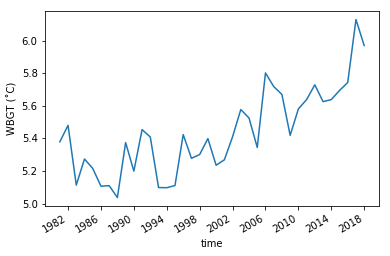

In [6]:
(wbgt_mean_ts.wbgt - 273.15).plot()
plt.ylabel('WBGT (˚C)')
plt.savefig(RESULTS_FOLDER / 'wbgt_yearly_mean.png', dpi=300)

In [12]:
wbgt_baseline = wbgt_mean.wbgt.sel(time=wbgt_mean.time.loc[f'{REFERENCE_YEAR_START}-01-01': f'{REFERENCE_YEAR_END}-12-31']).groupby('time.dayofyear').mean(dim='time')

In [13]:
def do_day_sub(year_data):
    year_data['time_bak'] = year_data['time']
    year_data['time'] = year_data['time.dayofyear']
    year_data = year_data.rename({'time': 'dayofyear'})
    # rename to align
    delta = year_data - wbgt_baseline
    delta['dayofyear'] = delta['time_bak']
    delta = delta.rename({'dayofyear': 'time'})
    delta = delta.drop('time_bak')
    return delta


wbgt_delta = wbgt_mean.wbgt.groupby('time.year').apply(do_day_sub)

In [14]:
cos_lat = np.cos(np.radians(wbgt_delta.latitude))

In [15]:
wbgt_delta_ts = (wbgt_delta.groupby('time.year').mean(dim='time') * cos_lat).mean(dim=['latitude', 'longitude']).compute()

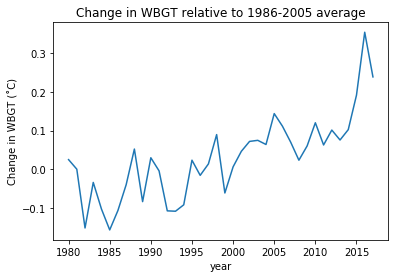

In [23]:
wbgt_delta_ts.plot()
plt.ylabel('Change in WBGT (˚C)')
plt.title('Change in WBGT relative to 1986-2005 average')
plt.savefig(RESULTS_FOLDER / 'wbgt_delta_mean.png', dpi=300)

In [16]:
import population_tools

In [17]:
wbgt_delta_popweight_ts = population_tools.project_to_population(wbgt_delta.groupby('time.year').mean(dim='time'), norm=True).compute()

In [18]:
df = wbgt_delta_ts.to_dataframe('wbgt_delta_mean').join(wbgt_delta_popweight_ts.to_dataframe('wbgt_delta_exposure'))
df.to_excel(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.xlsx')

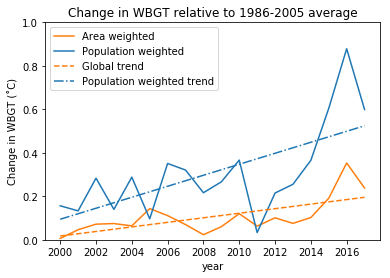

In [22]:
wbgt_delta_ts = wbgt_delta_ts.sel(year=slice(2000,None))
wbgt_delta_ts.plot(color='C1', label='Area weighted')
wbgt_delta_popweight_ts.plot(color='C0', label='Population weighted')


anom_reg = stats.linregress(wbgt_delta_ts.year.values, wbgt_delta_ts.values)
anom_reg = (anom_reg.slope * wbgt_delta_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(wbgt_delta_popweight_ts.year.values, wbgt_delta_popweight_ts.values)
exposures_reg = (exposures_reg.slope * wbgt_delta_popweight_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))

plt.ylim(0,1)
plt.ylabel('Change in WBGT (˚C)')
plt.title('Change in WBGT relative to 1986-2005 average')
plt.legend()
plt.savefig(RESULTS_FOLDER / 'wbgt_delta_yearly_mean.png', dpi=300)

# TODO more accurate method of calculating WBGT


In [ ]:
def fWBGTi(T_air, T_dew):
    # First step Psychrometric Wet bulb temperature calculation
    if T_dew > T_air:
        fWBGTi = T_air
        return fWBGTi

    # Iteration to get Tw from Td       
    Tw = T_dew
    Diff = 10000
    Ed = 0.6106 * np.exp(17.27 * T_dew / (237.3 + T_dew))
    while np.abs(Diff) + np.abs(Diffold) == np.abs(Diff + Diffold):
        Diffold = Diff
        Ew = 0.6106 * np.exp(17.27 * Tw / (237.3 + Tw))
        Diff = 1556 * Ed + 101 * Ta - 1556 * Ew + 1.484 * Ew * Tw - 1.484 * Ed * Tw - 101 * Tw
        Tw = Tw + 0.2
        if Tw > T_air:
            break
        
        if Tw > T_dew + 0.2:
            Tw = Tw - 0.2
        else:
            Tw = T_dew
    # Use Bernard formula to calculate natural wet bulb temperature from psychrometric wet bulb temperature for 1m/s wind speed
    fWBGTi = 0.67 * Tw + 0.33 * T_air
    return fWBGTi